### Topic Modelling ###

This notebook deals with the topic modelling section on the tweets dataset. Topic modelling is important for a text-based data analysis to understand the key topics behind a set of textual data for eventual feature engineering or classification. In this case, we are interested to see which topics may be relevant for actual disasters. 

The method to be used is Latent Dirichlet Allocation (LDA). LDA seeks to find the set of hidden topics that explain the observed patterns of word occurances across the documents (tweets)

In [167]:
#import libraries for topic modeling and LDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.utils import simple_preprocess


In [168]:
#import data
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [169]:
#summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Pre-Processing 

In [170]:
#remove keywords and location columns
df = df.drop(['keyword', 'location'], axis=1)

In [171]:
#print the unique values in 'target'
df['target'].unique()


array([1, 0], dtype=int64)

In [176]:
#remove stopwords in 'text' column
stop_words = set(stopwords.words('english'))

#remove special characters
df['text'] = df['text'].str.replace('[^\w\s]','')

#remove digits
df['text'] = df['text'].str.replace('\d+', '')

#retain only words with >= 3 characters
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#remove words with >= 15 characters
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)<15]))

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df.head()

C:\Users\alpho\AppData\Local\Temp\ipykernel_14800\2817915455.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')
C:\Users\alpho\AppData\Local\Temp\ipykernel_14800\2817915455.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


,id,text,target
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1
1,4,Forest fire near Ronge Sask Canada,1
2,5,All residents asked shelter place notified off...,1
3,6,people receive wildfires evacuation orders Cal...,1
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1


In [173]:
#split text into words
# df['text'] = df['text'].apply(lambda x: x.split())

#create noun_Verb column
# df['noun_verb'] = df['text'].apply(lambda x: [word for word,pos in pos_tag(x) if pos == 'NN' or pos == 'VB'])
# df['noun_verb'] = df['noun_verb'].apply(lambda x: ' '.join(x))
# df.head()

#### LDA

In [177]:
df.head()

,id,text,target
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1
1,4,Forest fire near Ronge Sask Canada,1
2,5,All residents asked shelter place notified off...,1
3,6,people receive wildfires evacuation orders Cal...,1
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1


In [178]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
count_data = count_vectorizer.fit_transform(df['text'])
vocab = count_vectorizer.get_feature_names()

n, m = count_data.shape
print('Number of documents: ', n)
k = 10

#build the LDA model using the mallet model using sklearn
lda_model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='online', random_state=0)
lda_model.fit(count_data)

#find the top 10 words in each topic
def print_topics(model, n_top_words):
    topic_word = model.components_

    for j in range(m):
        topic_word[:,j] /= sum(topic_word[:,j])
    for i in range(k):
        proj_j = []
        for j in range(m):
            proj_j.append((topic_word[i,j],j))
        
        prob_sorted = sorted(proj_j, reverse=True)
        print('topic',i+1)
        for j in range(n_top_words):
            print('    ', prob_sorted[j][0], vocab[prob_sorted[j][1]])

print_topics(lda_model, 10)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of documents:  7613
topic 1
     0.9921045309677845 day
     0.9869560004964024 accident
     0.0013015498717222386 years
     0.0012679164284044415 want
     0.0011782678919524982 today
     0.0011712719314924901 hiroshima
     0.0011521958040452615 say
     0.0011439520736431098 life
     0.0011417312375477347 watch
     0.0011410009841399085 buildings
topic 2
     0.9938103269291839 emergency
     0.9916609330919871 know
     0.9916117065028794 bomb
     0.9897046264485089 life
     0.0014492697784803446 accident
     0.0013015617612770975 years
     0.0012679323188746774 want
     0.0011782695560788898 today
     0.0011717839652957778 hiroshima
     0.0011522353737712988 say
topic 3
     0.9969039215744024 amp
     0.9920066560881908 got
     0.9909809559323385 love
     0.6736641605736221 video
     0.0014492711931188495 accident
     0.001301544152760427 years
     0.0012679289276295387 want
     0.0011782578036867906 today
     0.0011712592980037265 hiroshima
     0.00115

In [179]:
#create dataframe with the topic distribution for each document
topic_dist = lda_model.transform(count_data)
topic_dist = pd.DataFrame(topic_dist)
topic_dist.columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
topic_dist.head()


,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,0.033333,0.033333,0.033333,0.033333,0.033333,0.366667,0.033333,0.033333,0.033333,0.366667
4,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000


LatentDirichletAllocation(learning_method='online', random_state=0)


In [182]:
#append the topic distribution to the original dataframe
df = pd.concat([df, topic_dist], axis=1)
df.head()

,id,text,target,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,4,Forest fire near Ronge Sask Canada,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,5,All residents asked shelter place notified off...,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,6,people receive wildfires evacuation orders Cal...,1,0.033333,0.033333,0.033333,0.033333,0.033333,0.366667,0.033333,0.033333,0.033333,0.366667
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000


In [184]:
#based on the topic distribution, create a new column with the top topic for each document
df['top_topic'] = df[['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']].idxmax(axis=1)
df.head()

,id,text,target,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,top_topic
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
1,4,Forest fire near Ronge Sask Canada,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
2,5,All residents asked shelter place notified off...,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
3,6,people receive wildfires evacuation orders Cal...,1,0.033333,0.033333,0.033333,0.033333,0.033333,0.366667,0.033333,0.033333,0.033333,0.366667,topic10
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,topic3


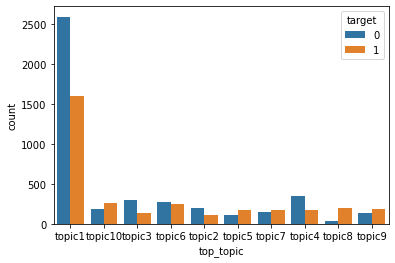

In [185]:
#plot the distribution of the top topic for each document
sns.countplot(x='top_topic', data=df, hue='target')
plt.show()

---